In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [4]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [5]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [6]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [7]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [8]:
input_size = 784
output_size = 10

In [9]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [10]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [11]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [12]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [13]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

In [77]:
class TopK_DT_AE(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_topk):
        super().__init__()
        self.dt = DistanceTransform(input_dim, output_dim)
        self.num_topk = num_topk
        
    def forward(self, x):
        dists = self.dt(x)
#         print(dists)
        dists_, indices = torch.topk(dists, self.num_topk, dim=1, sorted=False, largest=False)
        
        A = 2*(self.dt.centers[1:]-self.dt.centers[:-1])
        c2 = self.dt.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        invA = torch.pinverse(A)
        
        kdist = dists.data.max(dim=1, keepdim=True)[0].expand_as(dists).clone()
        kdist.scatter_(dim=1, index=indices, src=dists_)
#         print(kdist.shape)
#         print(kdist)
        
        d2 = kdist**2
        D = d2[:, :-1]-d2[:, 1:]

        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [78]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx_, _ = test_loader.dataset[indices]

In [79]:
dtae = TopK_DT_AE(784, 200, num_topk=100)
dtae.dt.set_centroid_to_data_randomly(test_loader)
dtae.to(device)
xrec_ = dtae(xx_.to(device))

## Train to reduce reconstruction error

In [80]:
dtae = TopK_DT_AE(784, 200, num_topk=100)
dtae.dt.set_centroid_to_data_randomly(train_loader)
dtae.dt.centers.data += torch.randn_like(dtae.dt.centers)*0.01
dtae.to(device)
xrec_ = dtae(xx_.to(device))

In [81]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx_, _ = test_loader.dataset[indices]

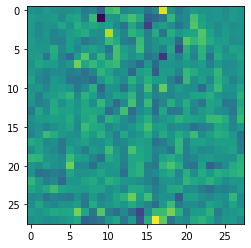

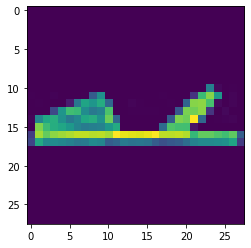

In [82]:
xrec_ = dtae(xx_.to(device))
i=0
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show()

In [83]:
optimizer = optim.Adam(list(dtae.parameters()), lr=0.01)
criterion = nn.MSELoss()

In [84]:
index = 0
train_error, test_error = [], []
dtae.train()
for epoch in tqdm(list(range(30))):
    train_err = 0
    train_count = 0
    
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        xrec = dtae(xx)
        
        loss = criterion(xrec, xx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_err += float(loss)*len(xx)
        train_count += len(xx)

    test_err = 0
    test_count = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            xrec = dtae(xx)
            loss = criterion(xrec, xx)
            test_err += float(loss)*len(xx)
            test_count += len(xx)
            
    train_error.append(train_err/train_count)
    test_error.append(test_err/test_count)
        
    print(f'Epoch: {epoch}:{index}, Train Error:{train_error[-1]:4f} Test Error:{test_error[-1]:4f}')

  3%|▎         | 1/30 [00:13<06:28, 13.41s/it]

Epoch: 0:0, Train Error:0.388958 Test Error:0.156567


  7%|▋         | 2/30 [00:26<06:13, 13.34s/it]

Epoch: 1:0, Train Error:0.253502 Test Error:0.246110


 10%|█         | 3/30 [00:39<05:57, 13.24s/it]

Epoch: 2:0, Train Error:0.236312 Test Error:0.234729


 13%|█▎        | 4/30 [00:52<05:41, 13.14s/it]

Epoch: 3:0, Train Error:0.237010 Test Error:0.243500


 17%|█▋        | 5/30 [01:05<05:27, 13.09s/it]

Epoch: 4:0, Train Error:0.257690 Test Error:0.269299


 17%|█▋        | 5/30 [01:13<06:05, 14.61s/it]


KeyboardInterrupt: 

In [ ]:
### With backprop in inv function
#Epoch: 29:0, Train Error:0.007772 Test Error:0.007768

### Without
#

In [225]:
dists = dt(xx_.to(device))
dt.compute_inverse_matrix()
xrec_2 = dt.inverse(dists)
i=0

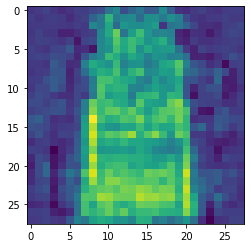

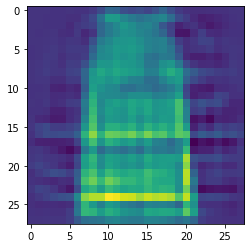

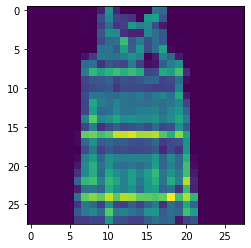

In [226]:
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xrec_2.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show(); i+=1

### Train linear autoencoder for comparision

In [90]:
class TopK_LinearAE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_topk):
        super().__init__()
        self.enc = nn.Linear(input_dim, hidden_dim)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        self.num_topk = num_topk
        
    def forward(self, x):
        h = self.enc(x)
        
        _, indices = torch.topk(h.abs(), self.num_topk, dim=1, largest=True, sorted=False)
        h_ = torch.zeros_like(h)
        h_.scatter_(dim=1, index=indices, src=torch.gather(h, dim=1, index=indices))
        
        
        w = self.enc.weight
#         w = torch.pinverse(self.enc.weight.t())

        xrec = torch.matmul(h_, w) + self.bias
        return xrec

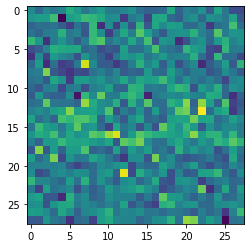

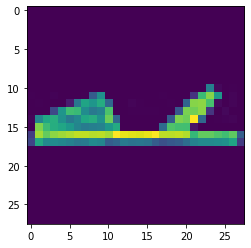

In [91]:
lae = TopK_DT_AE(784, 400, 100).to(device)

xrec_ = lae(xx_.to(device)); i=0
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show()

In [92]:
optimizer = optim.Adam(list(lae.parameters()), lr=0.001)
criterion = nn.MSELoss()

In [93]:
index = 0
train_error, test_error = [], []
lae.train()
for epoch in tqdm(list(range(30))):
    train_err = 0
    train_count = 0
    
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        xrec = lae(xx)
        
        loss = criterion(xrec, xx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_err += float(loss)*len(xx)
        train_count += len(xx)

    test_err = 0
    test_count = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            xrec = lae(xx)
            loss = criterion(xrec, xx)
            test_err += float(loss)*len(xx)
            test_count += len(xx)
            
    train_error.append(train_err/train_count)
    test_error.append(test_err/test_count)
        
    print(f'Epoch: {epoch}:{index}, Train Error:{train_error[-1]:4f} Test Error:{test_error[-1]:4f}')

  3%|▎         | 1/30 [00:30<14:39, 30.32s/it]

Epoch: 0:0, Train Error:0.056397 Test Error:0.031791


  7%|▋         | 2/30 [01:00<14:05, 30.21s/it]

Epoch: 1:0, Train Error:0.028716 Test Error:0.026644


 10%|█         | 3/30 [01:30<13:32, 30.10s/it]

Epoch: 2:0, Train Error:0.025768 Test Error:0.025254


 13%|█▎        | 4/30 [02:00<13:02, 30.10s/it]

Epoch: 3:0, Train Error:0.025236 Test Error:0.025442


 17%|█▋        | 5/30 [02:30<12:34, 30.18s/it]

Epoch: 4:0, Train Error:0.025730 Test Error:0.026011


 20%|██        | 6/30 [03:01<12:05, 30.24s/it]

Epoch: 5:0, Train Error:0.026652 Test Error:0.027204


 23%|██▎       | 7/30 [03:31<11:37, 30.32s/it]

Epoch: 6:0, Train Error:0.027732 Test Error:0.028149


 27%|██▋       | 8/30 [04:02<11:07, 30.35s/it]

Epoch: 7:0, Train Error:0.028758 Test Error:0.029047


 30%|███       | 9/30 [04:32<10:37, 30.37s/it]

Epoch: 8:0, Train Error:0.029694 Test Error:0.029940


 33%|███▎      | 10/30 [05:02<10:07, 30.38s/it]

Epoch: 9:0, Train Error:0.030483 Test Error:0.030916


 37%|███▋      | 11/30 [05:33<09:37, 30.38s/it]

Epoch: 10:0, Train Error:0.031215 Test Error:0.031677


 40%|████      | 12/30 [06:03<09:06, 30.38s/it]

Epoch: 11:0, Train Error:0.031844 Test Error:0.031534


 43%|████▎     | 13/30 [06:34<08:36, 30.41s/it]

Epoch: 12:0, Train Error:0.032400 Test Error:0.032408


 47%|████▋     | 14/30 [07:04<08:06, 30.41s/it]

Epoch: 13:0, Train Error:0.032941 Test Error:0.032731


 50%|█████     | 15/30 [07:35<07:36, 30.43s/it]

Epoch: 14:0, Train Error:0.033375 Test Error:0.033569


 53%|█████▎    | 16/30 [08:05<07:05, 30.43s/it]

Epoch: 15:0, Train Error:0.033834 Test Error:0.033886


 57%|█████▋    | 17/30 [08:35<06:35, 30.43s/it]

Epoch: 16:0, Train Error:0.034230 Test Error:0.034414


 60%|██████    | 18/30 [09:06<06:05, 30.43s/it]

Epoch: 17:0, Train Error:0.034606 Test Error:0.034880


 63%|██████▎   | 19/30 [09:36<05:34, 30.38s/it]

Epoch: 18:0, Train Error:0.034925 Test Error:0.034677


 67%|██████▋   | 20/30 [10:07<05:03, 30.40s/it]

Epoch: 19:0, Train Error:0.035267 Test Error:0.035413


 70%|███████   | 21/30 [10:37<04:33, 30.41s/it]

Epoch: 20:0, Train Error:0.035571 Test Error:0.035533


 73%|███████▎  | 22/30 [11:07<04:03, 30.43s/it]

Epoch: 21:0, Train Error:0.035845 Test Error:0.036003


 77%|███████▋  | 23/30 [11:38<03:32, 30.42s/it]

Epoch: 22:0, Train Error:0.036110 Test Error:0.035967


 80%|████████  | 24/30 [12:08<03:02, 30.43s/it]

Epoch: 23:0, Train Error:0.036364 Test Error:0.036260


 83%|████████▎ | 25/30 [12:39<02:32, 30.42s/it]

Epoch: 24:0, Train Error:0.036584 Test Error:0.036754


 87%|████████▋ | 26/30 [13:09<02:01, 30.42s/it]

Epoch: 25:0, Train Error:0.036832 Test Error:0.036988


 90%|█████████ | 27/30 [13:40<01:31, 30.41s/it]

Epoch: 26:0, Train Error:0.037063 Test Error:0.037201


 90%|█████████ | 27/30 [14:06<01:34, 31.36s/it]


KeyboardInterrupt: 

In [96]:
xrec_3 = lae(xx_.to(device))
i=0

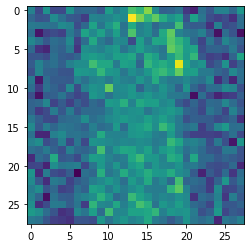

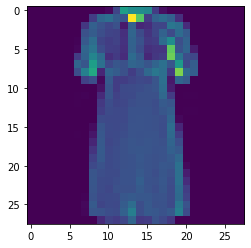

In [102]:
# plt.imshow(xrec_2.data[i].cpu().reshape(28,28))
# plt.show()
plt.imshow(xrec_3.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show(); i+=1